<a href="https://colab.research.google.com/github/Dipsann-cloud/Dipsan.check/blob/main/plant_disease_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Dataset**

In [1]:
import os
import kagglehub
import shutil

dataset_path = kagglehub.dataset_download('fakhrealam9537/leaf-disease-segmentation-dataset')
print(f"Dataset downloaded to: {dataset_path}")


download_path = '/content/leaf_disease'


if os.path.exists(download_path):
    shutil.rmtree(download_path)
os.makedirs(download_path, exist_ok=True)

# defining src paths
source_data = os.path.join(dataset_path, 'data/data')
source_aug = os.path.join(dataset_path, 'aug_data/aug_data')

# Copying to content dir
shutil.copytree(os.path.join(source_data, 'images'),
                os.path.join(download_path, 'data/images'))
shutil.copytree(os.path.join(source_data, 'masks'),
                os.path.join(download_path, 'data/masks'))
shutil.copytree(os.path.join(source_aug, 'images'),
                os.path.join(download_path, 'aug_data/images'))
shutil.copytree(os.path.join(source_aug, 'masks'),
                os.path.join(download_path, 'aug_data/masks'))

print(f"\nCleaned dataset structure at: {download_path}")
print("\nNew structure:")
os.system(f"tree -L 3 {download_path}")

100%|██████████| 503M/503M [00:23<00:00, 22.2MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/fakhrealam9537/leaf-disease-segmentation-dataset/versions/4

Cleaned dataset structure at: /content/leaf_disease

New structure:


32512

**imports**

In [2]:
import os
import random
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import cv2
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix


## **Data Separation**

In [ ]:

working_dir = '/content/dataset'

kfold_base_dir = os.path.join(working_dir, 'kfold')


test_image_dir = os.path.join(working_dir, 'test/images')
test_mask_dir = os.path.join(working_dir, 'test/masks')



print(f"Test Holdout Image Directory: {test_image_dir}")
print(f"Test Holdout Mask Directory: {test_mask_dir}")

Test Holdout Image Directory: /content/dataset/test/images
Test Holdout Mask Directory: /content/dataset/test/masks


In [ ]:
os.makedirs(kfold_base_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

In [ ]:

# src dir from initial data download
image_src_dir = '/content/leaf_disease/aug_data/images'
mask_src_dir = '/content/leaf_disease/aug_data/masks'


all_image_files = os.listdir(image_src_dir)
random.seed(42)
random.shuffle(all_image_files)

# Calculating split indices (85% for k-fold, 15% for  test)
total_files = len(all_image_files)
kfold_split_ratio = 0.85
kfold_end = int(total_files * kfold_split_ratio)

kfold_files = all_image_files[:kfold_end]
test_files = all_image_files[kfold_end:]

print(f"Total files: {total_files}")
print(f"Files for K-Fold: {len(kfold_files)} ({len(kfold_files)/total_files*100:.1f}%)")
print(f"Files for Holdout Test: {len(test_files)} ({len(test_files)/total_files*100:.1f}%)")



Total files: 2940
Files for K-Fold: 2499 (85.0%)
Files for Holdout Test: 441 (15.0%)


In [ ]:
def copy_data_to_destination(file_list , src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir) -> int:

    copied_count = 0

    missing_masks = []


    for image_file in file_list:
        src_image_path = os.path.join(src_img_dir, image_file)
        file_name_no_ext = os.path.splitext(image_file)[0]
        mask_file_name = file_name_no_ext + ".png"
        src_mask_path = os.path.join(src_mask_dir, mask_file_name)

        # Fallback: try same extension as image
        if not os.path.exists(src_mask_path):
            src_mask_path = os.path.join(src_mask_dir, image_file)

        if os.path.exists(src_mask_path):
            shutil.copy(src_image_path, os.path.join(dst_img_dir, image_file))
            shutil.copy(src_mask_path, os.path.join(dst_mask_dir, mask_file_name))
            copied_count += 1
        else:
            missing_masks.append(image_file)

    if missing_masks:
        print(f"  Warning: {len(missing_masks)} images missing masks for this split.")
    return copied_count



In [ ]:
# Note: K-fold data will be copied directly from original source when creating folds.
#  copying test set is done here only

# test dir
test_copied_count = copy_data_to_destination(test_files, image_src_dir, mask_src_dir,
                                                      test_image_dir, test_mask_dir)
print(f"Copied {test_copied_count} image-mask pairs to Holdout Test directories.")

Copied 441 image-mask pairs to Holdout Test directories.


In [ ]:
# making K fold dirs
kfolds = 5

# Base directory for kfold data (from previous step)
kfold_base_dir = os.path.join(working_dir, 'kfold')

for i in range(kfolds):
    fold_dir = os.path.join(kfold_base_dir, f'fold_{i}')

    # Creatin directories
    os.makedirs(os.path.join(fold_dir, 'train/images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'train/masks'), exist_ok=True)


    os.makedirs(os.path.join(fold_dir, 'val/images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'val/masks'), exist_ok=True)



## K-Folds

In [ ]:

kfold_image_source_dir = image_src_dir
kfold_mask_source_dir = mask_src_dir

# sorting for consistent splitting
kfold_files_sorted = sorted(kfold_files)

kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)

print(f"Performing {kfolds}-fold cross-validation data splitting...")

for fold, (train_index, val_index) in enumerate(kf.split(kfold_files_sorted)):
    print(f"\nProcessing Fold {fold}:")

    #  file names for current fold train and validation sets
    train_fold_files = [kfold_files_sorted[i] for i in train_index]
    val_fold_files = [kfold_files_sorted[i] for i in val_index]

    # desti loca for the current fold
    current_fold_base_dir = os.path.join(kfold_base_dir, f'fold_{fold}')
    train_img_dst = os.path.join(current_fold_base_dir, 'train/images')
    train_mask_dst = os.path.join(current_fold_base_dir, 'train/masks')
    val_img_dst = os.path.join(current_fold_base_dir, 'val/images')
    val_mask_dst = os.path.join(current_fold_base_dir, 'val/masks')

    # putin training data for the current fold
    train_copied_count = copy_data_to_destination(train_fold_files,
                                                  kfold_image_source_dir, kfold_mask_source_dir,
                                                  train_img_dst, train_mask_dst)
    print(f"  Copied {train_copied_count} training image-mask pairs to fold_{fold}.")


    val_copied_count = copy_data_to_destination(val_fold_files,
                                                kfold_image_source_dir, kfold_mask_source_dir,
                                                val_img_dst, val_mask_dst)
    print(f"  Copied {val_copied_count} validation image-mask pairs to fold_{fold}.")

print("K-Fold data splitting and copying complete.")

Performing 5-fold cross-validation data splitting...

Processing Fold 0:
  Copied 1999 training image-mask pairs to fold_0.
  Copied 500 validation image-mask pairs to fold_0.

Processing Fold 1:
  Copied 1999 training image-mask pairs to fold_1.
  Copied 500 validation image-mask pairs to fold_1.

Processing Fold 2:
  Copied 1999 training image-mask pairs to fold_2.
  Copied 500 validation image-mask pairs to fold_2.

Processing Fold 3:
  Copied 1999 training image-mask pairs to fold_3.
  Copied 500 validation image-mask pairs to fold_3.

Processing Fold 4:
  Copied 2000 training image-mask pairs to fold_4.
  Copied 499 validation image-mask pairs to fold_4.
K-Fold data splitting and copying complete.


In [ ]:
# Note this is just a random sampling of given dir

def display_sample_images(image_dir, mask_dir, title, num_samples=3):
    print(f"\n{title}")
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    if not image_files:
        print(f"No image files found in {image_dir}")
        return


    selected_files = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 5 * len(selected_files)))
    for i, image_file in enumerate(selected_files):
        img_path = os.path.join(image_dir, image_file)


        file_name_no_ext = os.path.splitext(image_file)[0]
        mask_file_name = file_name_no_ext + ".png"
        src_mask_path = os.path.join(mask_dir, mask_file_name)

        if not os.path.exists(src_mask_path):
            src_mask_path = os.path.join(mask_dir, image_file)

        if not os.path.exists(img_path) or not os.path.exists(src_mask_path):
            print(f"Skipping {image_file}: image or mask not found.")
            continue

        img = Image.open(img_path)
        mask = Image.open(src_mask_path)

        plt.subplot(len(selected_files), 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Image: {image_file}")
        plt.axis('off')

        plt.subplot(len(selected_files), 2, 2 * i + 2)
        plt.imshow(mask) # currently not using cmap="gray"
        plt.title(f"Mask: {mask_file_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()





--- K-Fold Fold 0 Training Set Samples ---


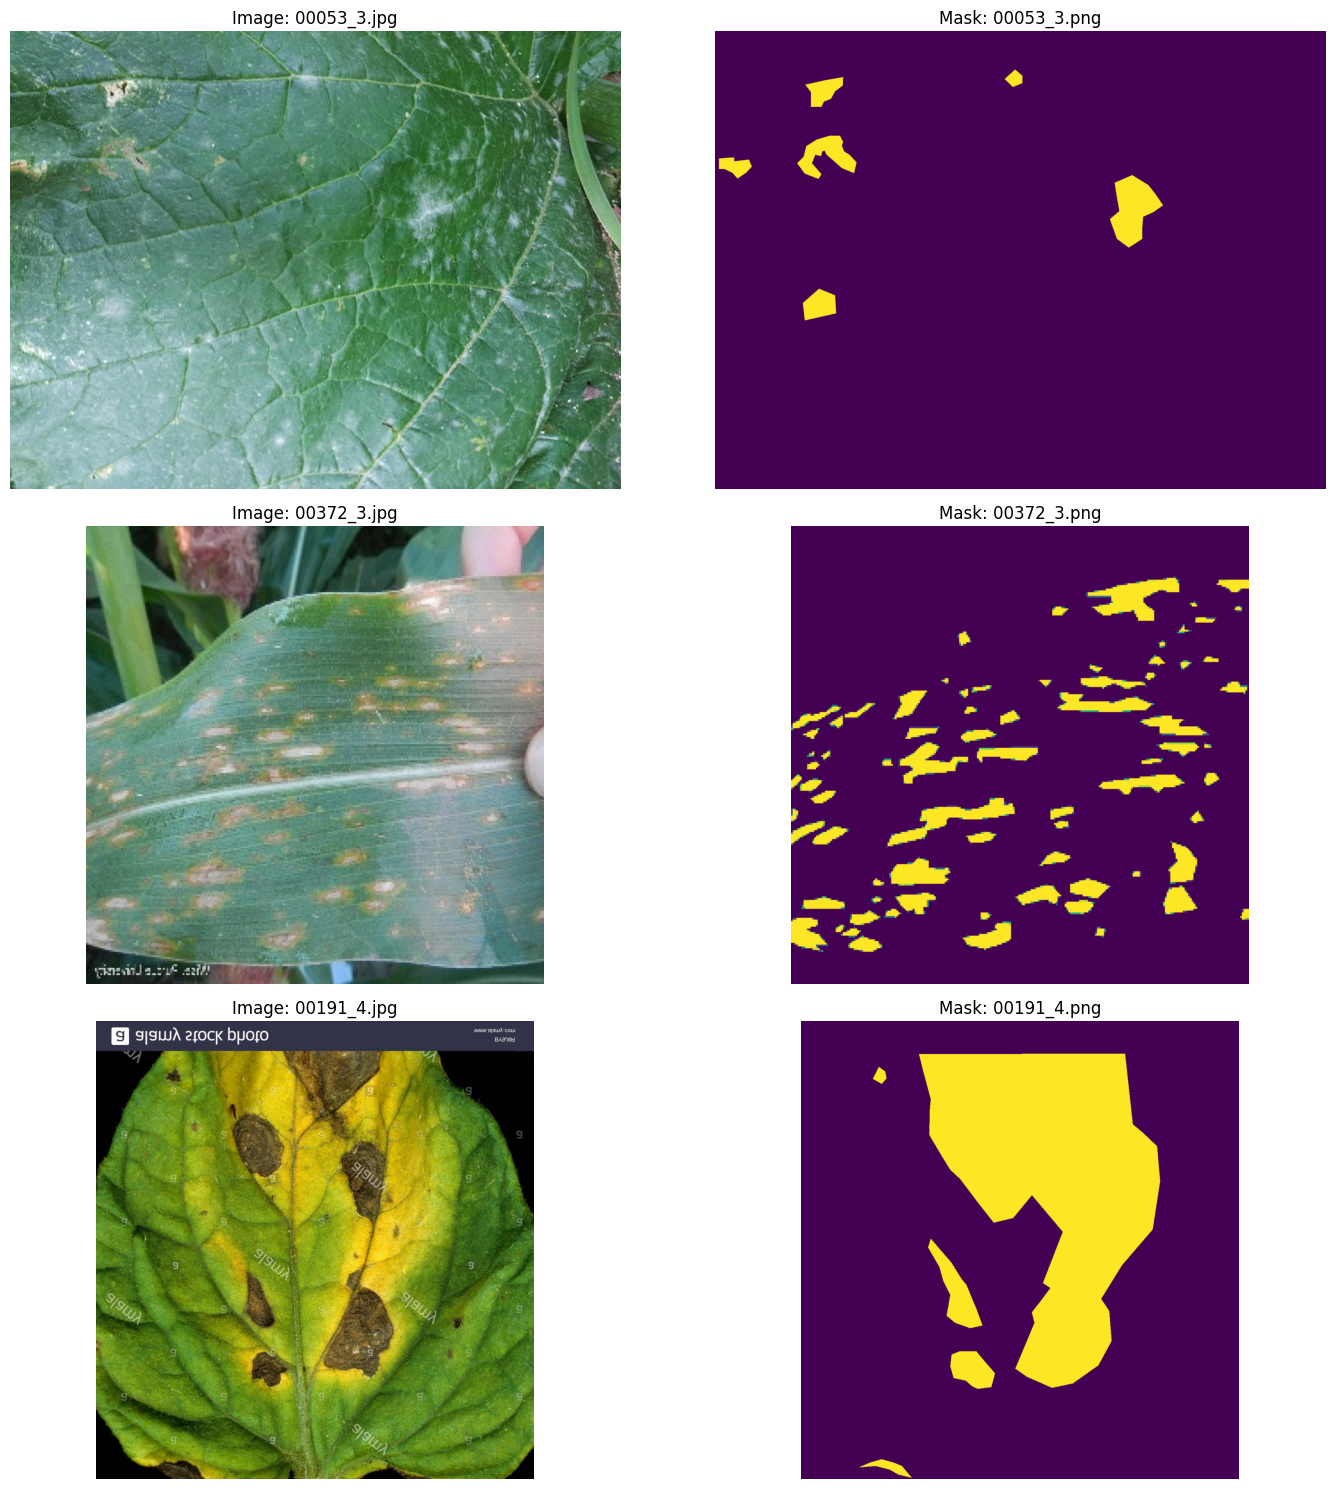


--- K-Fold Fold 0 Validation Set Samples ---


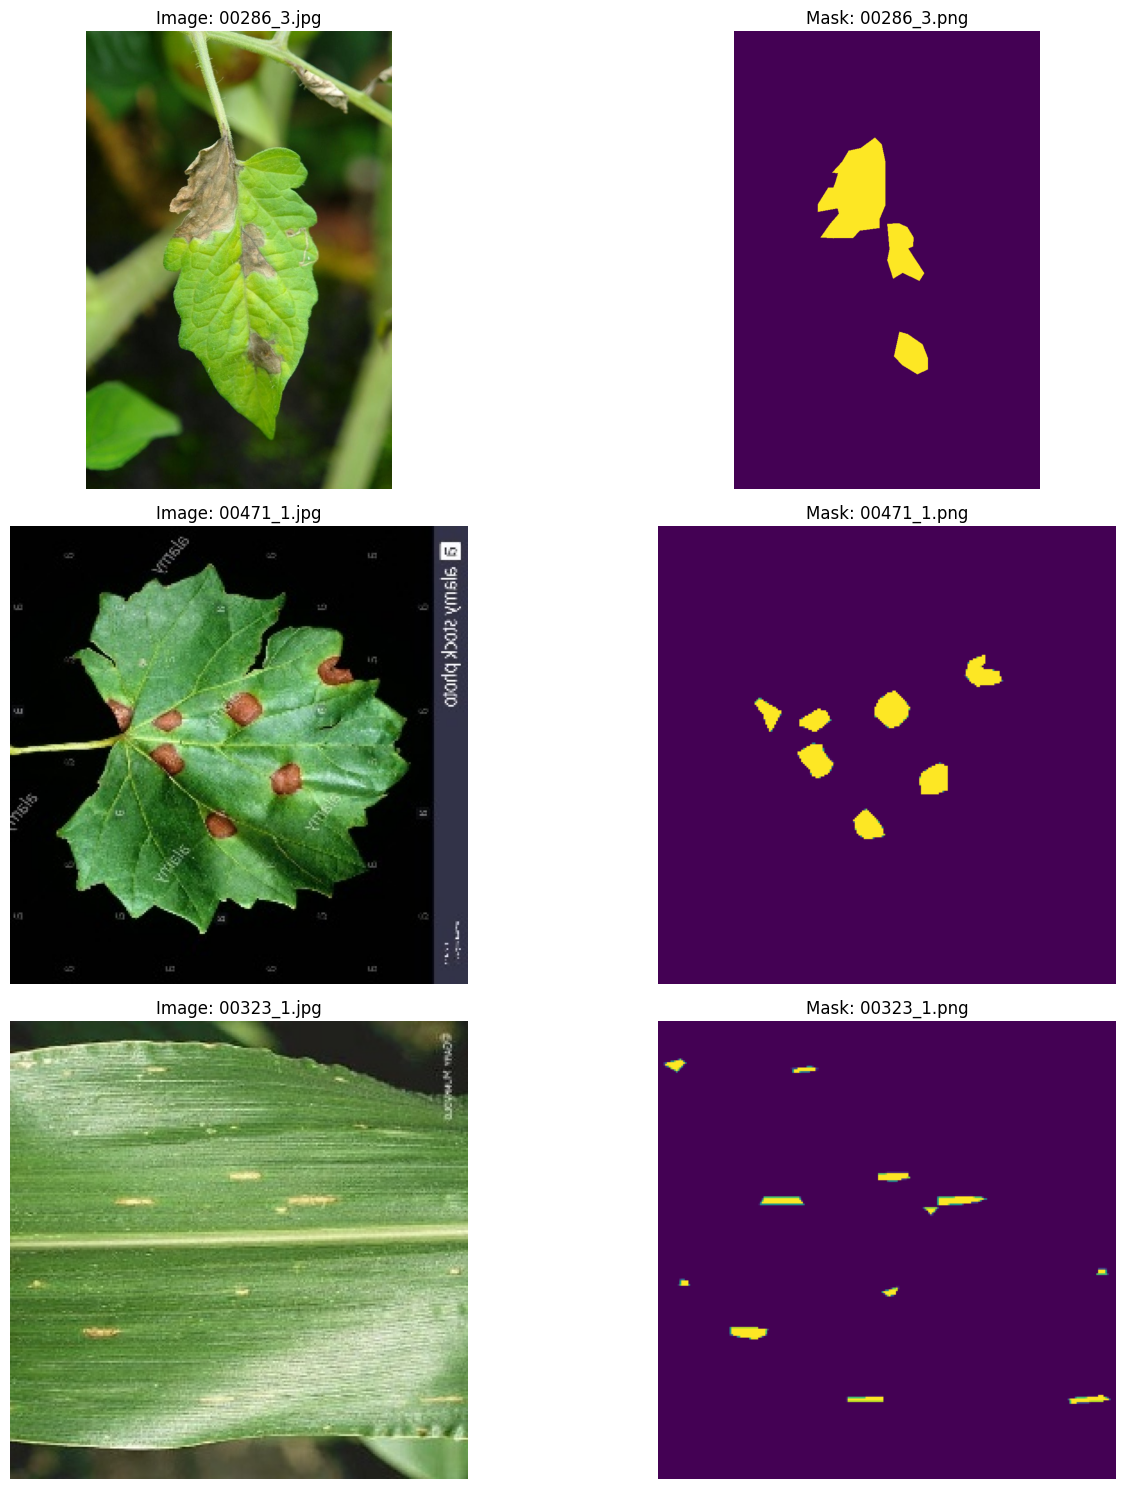


--- Holdout Test Set Samples ---


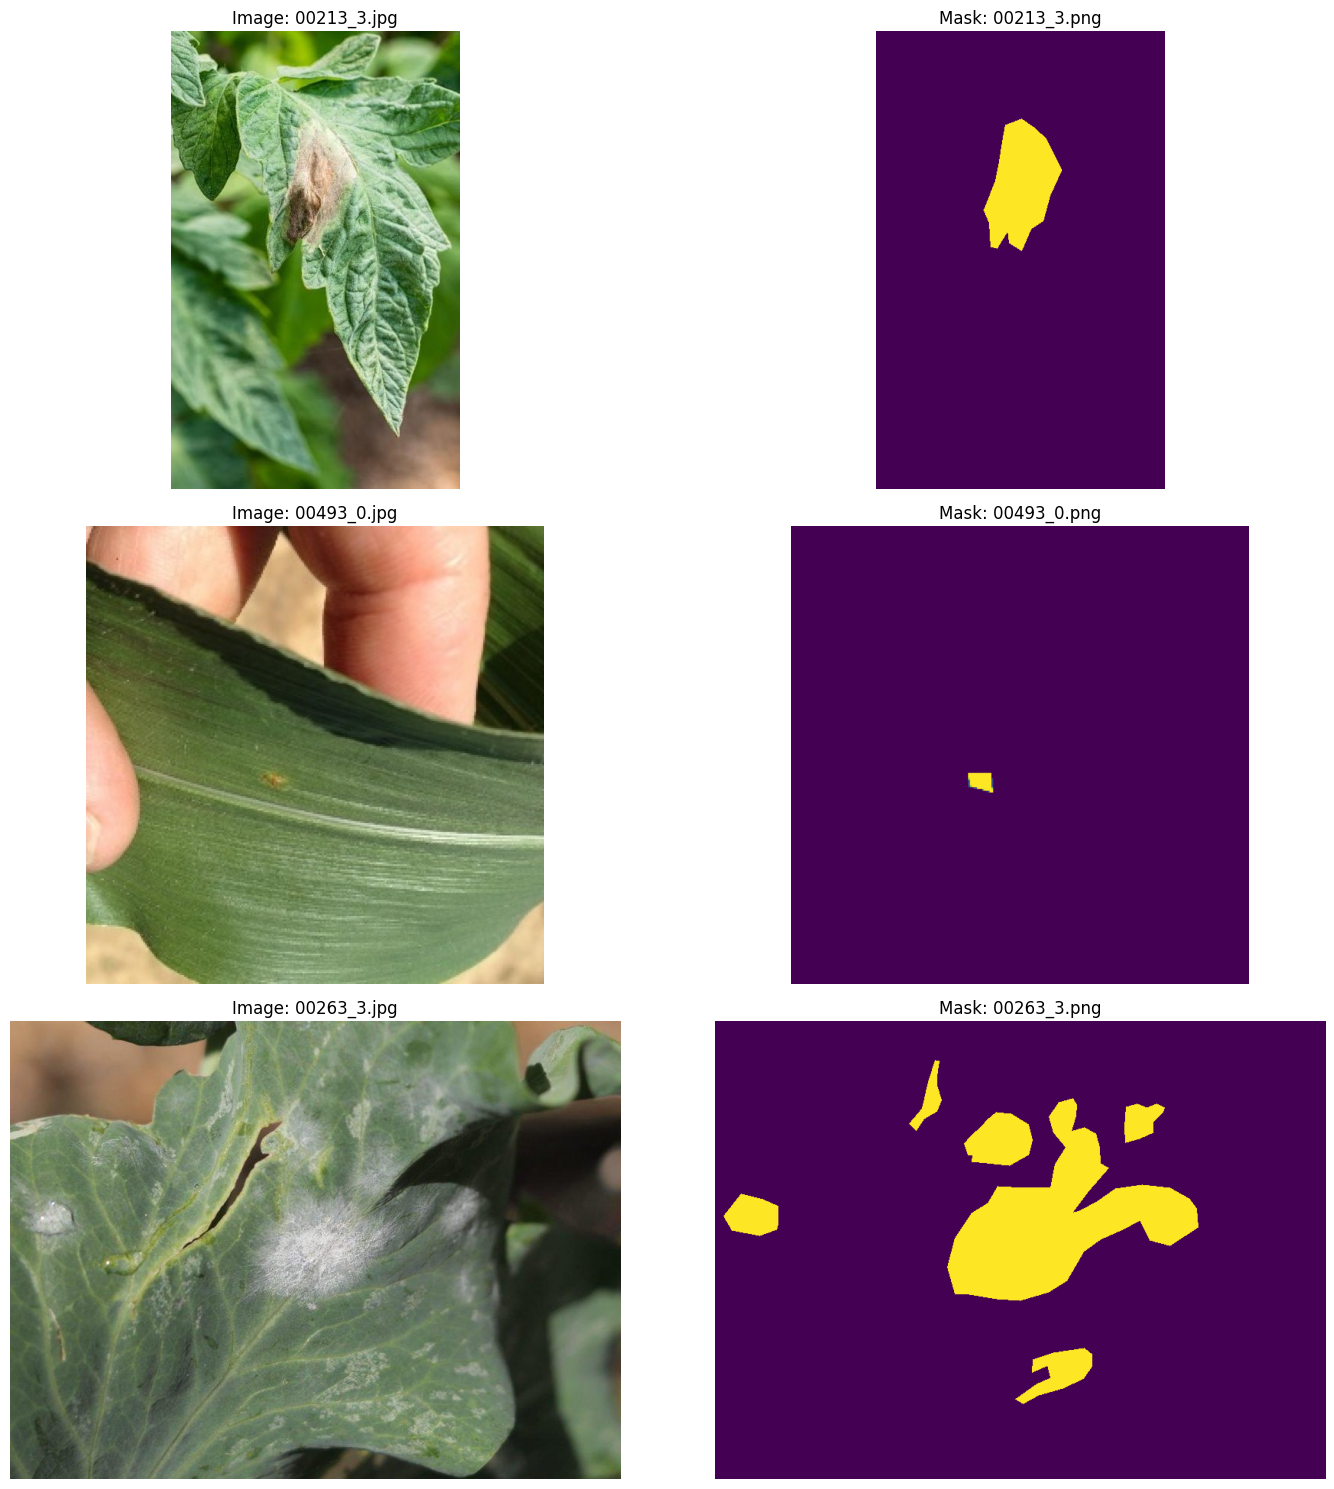

In [ ]:
# testing visualizatoin

# train set
fold_0_train_image_dir = os.path.join(kfold_base_dir, 'fold_0/train/images')
fold_0_train_mask_dir = os.path.join(kfold_base_dir, 'fold_0/train/masks')
display_sample_images(fold_0_train_image_dir, fold_0_train_mask_dir, "K-Fold Fold 0 Training Set Samples")

#val set
fold_0_val_image_dir = os.path.join(kfold_base_dir, 'fold_0/val/images')
fold_0_val_mask_dir = os.path.join(kfold_base_dir, 'fold_0/val/masks')
display_sample_images(fold_0_val_image_dir, fold_0_val_mask_dir, "K-Fold Fold 0 Validation Set Samples")

#  test set
display_sample_images(test_image_dir, test_mask_dir, "Holdout Test Set Samples")

In [ ]:

# Define image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Image Resize and Adjustments

In [ ]:
def load_and_resize_data(image_dir, mask_dir, num_samples, save_sizes=False):
    """
    Load and resize images and masks to fixed dimensions

    Args:
        image_dir: Directory containing images
        mask_dir: Directory containing masks
        num_samples: Number of samples to load
        save_sizes: Whether to save original sizes (useful for test set)

    Returns:
        X: Resized images array
        Y: Resized masks array (None if masks don't exist)
        sizes: Original sizes (if save_sizes=True)
    """
    image_files = sorted(os.listdir(image_dir))
    image_files = [f for f in image_files if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files = image_files[:num_samples]

    # Initialize arrays
    X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y = None
    sizes = [] if save_sizes else None

    # Check if masks exist
    has_masks = os.path.exists(mask_dir) and len(os.listdir(mask_dir)) > 0

    if has_masks:
        Y = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print(f'Processing {len(image_files)} images from {image_dir}')

    for i in tqdm(range(len(image_files)), desc='Loading and resizing'):
        #  resize image
        img_path = os.path.join(image_dir, image_files[i])
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        if save_sizes:
            sizes.append([img_array.shape[0], img_array.shape[1]])

        img_resized = resize(img_array, (IMG_HEIGHT, IMG_WIDTH),
                            mode='constant', preserve_range=True)
        X[i] = img_resized.astype(np.uint8)


        if has_masks:
            file_name_no_ext = os.path.splitext(image_files[i])[0]
            mask_file = file_name_no_ext + ".png"
            mask_path = os.path.join(mask_dir, mask_file)

            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
                mask_array = np.array(mask)
                mask_resized = resize(mask_array, (IMG_HEIGHT, IMG_WIDTH),
                                     mode='constant', preserve_range=True)
                Y[i] = np.expand_dims(mask_resized > 0, axis=-1)  # Binary masking baccha log

    return X, Y, sizes

In [ ]:

FOLD_NUMBER = 0  #in our case it ranges from (0-4)


fold_dir = os.path.join(kfold_base_dir, f'fold_{FOLD_NUMBER}')

train_image_dir = os.path.join(fold_dir, 'train/images')
train_mask_dir = os.path.join(fold_dir, 'train/masks')
val_image_dir = os.path.join(fold_dir, 'val/images')
val_mask_dir = os.path.join(fold_dir, 'val/masks')


num_train_samples = len([f for f in os.listdir(train_image_dir)
                         if f.endswith(('.jpg', '.jpeg', '.png'))])
num_val_samples = len([f for f in os.listdir(val_image_dir)
                       if f.endswith(('.jpg', '.jpeg', '.png'))])
num_test_samples = len([f for f in os.listdir(test_image_dir)
                        if f.endswith(('.jpg', '.jpeg', '.png'))])


print(f"\nUsing Fold {FOLD_NUMBER}")
print(f"\nTraining samples: {num_train_samples}")
print(f"\nValidation samples: {num_val_samples}")
print(f"\nTest samples: {num_test_samples}")



Using Fold 0

Training samples: 1999

Validation samples: 500

Test samples: 441


In [ ]:
#  training data
X_train, Y_train, _ = load_and_resize_data(
    train_image_dir,
    train_mask_dir,
    num_train_samples,
    save_sizes=False
)

print(f"\nTraining data shape:")
print(f"  X_train: {X_train.shape}")
print(f"  Y_train: {Y_train.shape}")
print(f"  X_train dtype: {X_train.dtype}")
print(f"  Y_train dtype: {Y_train.dtype}")

Processing 1999 images from /content/dataset/kfold/fold_0/train/images


Loading and resizing: 100%|██████████| 1999/1999 [06:59<00:00,  4.77it/s] 


Training data shape:
  X_train: (1999, 128, 128, 3)
  Y_train: (1999, 128, 128, 1)
  X_train dtype: uint8
  Y_train dtype: bool


In [ ]:
#  validation data
X_val, Y_val, _ = load_and_resize_data(
    val_image_dir,
    val_mask_dir,
    num_val_samples,
    save_sizes=False
)

print(f"\nValidation data shape:")
print(f"  X_val: {X_val.shape}")
print(f"  Y_val: {Y_val.shape}")

Processing 500 images from /content/dataset/kfold/fold_0/val/images


Loading and resizing: 100%|██████████| 500/500 [01:20<00:00,  6.20it/s]


Validation data shape:
  X_val: (500, 128, 128, 3)
  Y_val: (500, 128, 128, 1)


In [ ]:
#  test data NOTE -> (this time save original sizes for later evaluation)
X_test, Y_test, sizes_test = load_and_resize_data(
    test_image_dir,
    test_mask_dir,
    num_test_samples,
    save_sizes=True
)

print(f"\nTest data shape:")
print(f"  X_test: {X_test.shape}")
print(f"  Y_test: {Y_test.shape}")
print(f"  Original sizes saved: {len(sizes_test)}")

Processing 441 images from /content/dataset/test/images


Loading and resizing: 100%|██████████| 441/441 [01:43<00:00,  4.28it/s] 


Test data shape:
  X_test: (441, 128, 128, 3)
  Y_test: (441, 128, 128, 1)
  Original sizes saved: 441


### Visualization of imgs after reszie

Training Samples:


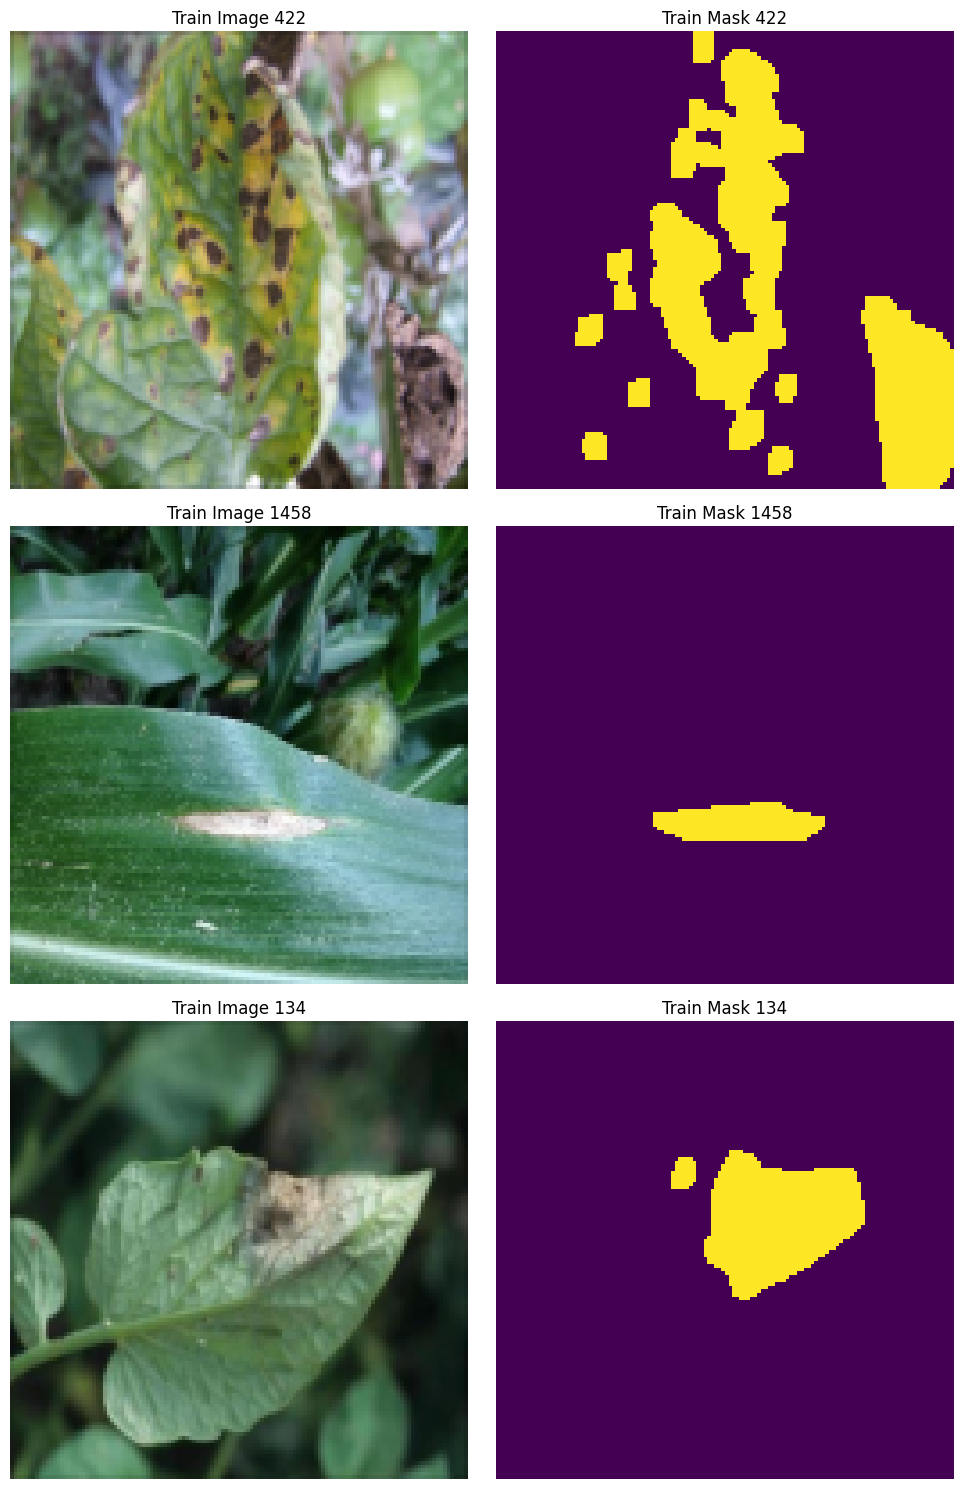


Validation Samples:


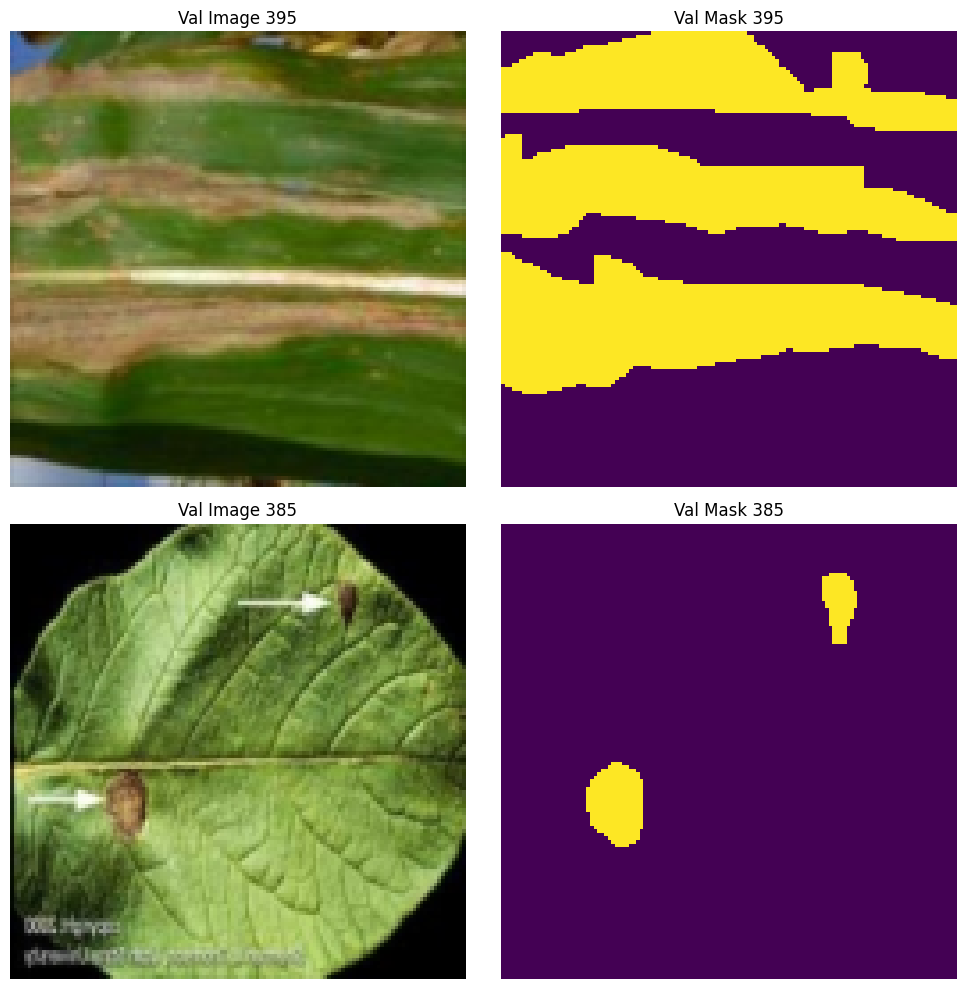

In [ ]:
def visualize_samples(X, Y, num_samples=3, title_prefix=""):
    """Visualize random samples from the dataset"""

    indices = np.random.choice(len(X), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for idx, sample_idx in enumerate(indices):
        # for img
        axes[idx, 0].imshow(X[sample_idx])
        axes[idx, 0].set_title(f'{title_prefix} Image {sample_idx}')
        axes[idx, 0].axis('off')

        # fot mask
        axes[idx, 1].imshow(np.squeeze(Y[sample_idx]),) # for now disabled cmap='gray'
        axes[idx, 1].set_title(f'{title_prefix} Mask {sample_idx}')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()


print("Training Samples:")
visualize_samples(X_train, Y_train, num_samples=3, title_prefix="Train")


print("\nValidation Samples:")
visualize_samples(X_val, Y_val, num_samples=2, title_prefix="Val")

In [ ]:
# Normalization of  images to [0, 1] range
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Convert masks to float
Y_train_norm = Y_train.astype('float32')
Y_val_norm = Y_val.astype('float32')
Y_test_norm = Y_test.astype('float32')

print(f"X_train_norm range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")
print(f"Y_train_norm range: [{Y_train_norm.min():.3f}, {Y_train_norm.max():.3f}]")

X_train_norm range: [0.000, 1.000]
Y_train_norm range: [0.000, 1.000]


## Building U-Net Model

In [ ]:
def build_unet_model(input_shape: tuple = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) -> tf.keras.Model:
    inputs = tf.keras.layers.Input(input_shape)

    # Contraction path with Batch Normalization
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Dropout(0.2)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Dropout(0.2)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Dropout(0.3)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Dropout(0.3)(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Dropout(0.4)(c5)

    # Expansive path with Batch Normalization
    u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)

    u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Dropout(0.3)(c7)

    u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)

    u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


## valdiation Metrices

In [ ]:

def dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float = 1e-6) -> tf.Tensor:
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))

def dice_coefficient(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float = 1e-6) -> tf.Tensor:
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) +
                                           tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float = 1e-6) -> tf.Tensor:
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def combined_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def create_generators(X: np.ndarray, Y: np.ndarray, batch_size: int = 16, augment: bool = False):
    if augment:
        datagen = train_datagen
    else:
        datagen = ImageDataGenerator()

    seed = 42

    image_generator = datagen.flow(X, batch_size=batch_size, seed=seed)
    mask_generator = datagen.flow(Y, batch_size=batch_size, seed=seed)

    while True:
        x_batch = next(image_generator)
        y_batch = next(mask_generator)
        yield x_batch, y_batch

## model Compilation

In [ ]:
model = build_unet_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy', dice_coefficient, iou_metric]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]  

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:

callbacks = [
    ModelCheckpoint(
        'model.h5',
        monitor='val_dice_coefficient',
        mode='max',
        verbose=1,
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_dice_coefficient',
        mode='max',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    TensorBoard(log_dir='logs')
]

In [ ]:


# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect'
)



In [ ]:

#  steps
batch_size = 16
steps_per_epoch = len(X_train_norm) // batch_size
validation_steps = len(X_val_norm) // batch_size

#  generators
train_generator = create_generators(X_train_norm, Y_train_norm, batch_size=batch_size, augment=True)
val_generator = create_generators(X_val_norm, Y_val_norm, batch_size=batch_size, augment=False)





## Trainning Data

In [ ]:
#  model Trainning
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5874 - dice_coefficient: 0.3818 - iou_metric: 0.2379 - loss: 1.3854
Epoch 1: val_dice_coefficient improved from -inf to 0.28990, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.5879 - dice_coefficient: 0.3821 - iou_metric: 0.2382 - loss: 1.3844 - val_accuracy: 0.7907 - val_dice_coefficient: 0.2899 - val_iou_metric: 0.1699 - val_loss: 1.1916 - learning_rate: 1.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7686 - dice_coefficient: 0.5022 - iou_metric: 0.3365 - loss: 1.0522
Epoch 2: val_dice_coefficient improved from 0.28990 to 0.32981, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.7686 - dice_coefficient: 0.5022 - iou_metric: 0.3365 - loss: 1.0521 - val_accuracy: 0.8109 - val_dice_coefficient: 0.3298 - val_iou_metric: 0.1984 - val_loss: 1.1498 - learning_rate: 1.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7886 - dice_coefficient: 0.5158 - iou_metric: 0.3496 - loss: 1.0084
Epoch 3: val_dice_coefficient improved from 0.32981 to 0.41645, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.7887 - dice_coefficient: 0.5159 - iou_metric: 0.3497 - loss: 1.0079 - val_accuracy: 0.8304 - val_dice_coefficient: 0.4164 - val_iou_metric: 0.2653 - val_loss: 1.0640 - learning_rate: 1.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8080 - dice_coefficient: 0.5474 - iou_metric: 0.3787 - loss: 0.9133
Epoch 4: val_dice_coefficient improved from 0.41645 to 0.54202, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8080 - dice_coefficient: 0.5475 - iou_metric: 0.3788 - loss: 0.9130 - val_accuracy: 0.8658 - val_dice_coefficient: 0.5420 - val_iou_metric: 0.3733 - val_loss: 0.8369 - learning_rate: 1.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8092 - dice_coefficient: 0.5376 - iou_metric: 0.3704 - loss: 0.9595
Epoch 5: val_dice_coefficient improved from 0.54202 to 0.62032, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8093 - dice_coefficient: 0.5378 - iou_metric: 0.3706 - loss: 0.9587 - val_accuracy: 0.8632 - val_dice_coefficient: 0.6203 - val_iou_metric: 0.4524 - val_loss: 0.8563 - learning_rate: 1.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8174 - dice_coefficient: 0.5618 - iou_metric: 0.3948 - loss: 0.9022
Epoch 6: val_dice_coefficient improved from 0.62032 to 0.63321, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8175 - dice_coefficient: 0.5620 - iou_metric: 0.3950 - loss: 0.9015 - val_accuracy: 0.8803 - val_dice_coefficient: 0.6332 - val_iou_metric: 0.4643 - val_loss: 0.7638 - learning_rate: 1.0000e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8206 - dice_coefficient: 0.5599 - iou_metric: 0.3931 - loss: 0.8931
Epoch 7: val_dice_coefficient improved from 0.63321 to 0.64751, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.8207 - dice_coefficient: 0.5602 - iou_metric: 0.3933 - loss: 0.8923 - val_accuracy: 0.8694 - val_dice_coefficient: 0.6475 - val_iou_metric: 0.4803 - val_loss: 0.7206 - learning_rate: 1.0000e-04
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8476 - dice_coefficient: 0.6321 - iou_metric: 0.4634 - loss: 0.7174
Epoch 8: val_dice_coefficient did not improve from 0.64751
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.8476 - dice_coefficient: 0.6321 - iou_metric: 0.4634 - loss: 0.7174 - val_accuracy: 0.8854 - val_dice_coefficient: 0.6436 - val_iou_metric: 0.4763 - val_loss: 0.6888 - learning_rate: 1.0000e-04
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8234 - dice_coefficient: 0.5908 - iou_metric: 0.4226 - loss: 0.8653
Epoch 9: val_dice_coefficient improved from 0.64751 to 0.66039, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.8235 - dice_coefficient: 0.5910 - iou_metric: 0.4228 - loss: 0.8645 - val_accuracy: 0.8814 - val_dice_coefficient: 0.6604 - val_iou_metric: 0.4948 - val_loss: 0.7084 - learning_rate: 1.0000e-04
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8324 - dice_coefficient: 0.5921 - iou_metric: 0.4267 - loss: 0.8542
Epoch 10: val_dice_coefficient improved from 0.66039 to 0.68279, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.8325 - dice_coefficient: 0.5924 - iou_metric: 0.4269 - loss: 0.8532 - val_accuracy: 0.8890 - val_dice_coefficient: 0.6828 - val_iou_metric: 0.5203 - val_loss: 0.6285 - learning_rate: 1.0000e-04
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8352 - dice_coefficient: 0.6006 - iou_metric: 0.4343 - loss: 0.8243
Epoch 11: val_dice_coefficient did not improve from 0.68279
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.8353 - dice_coefficient: 0.6009 - iou_metric: 0.4346 - loss: 0.8234 - val_accuracy: 0.8745 - val_dice_coefficient: 0.6710 - val_iou_metric: 0.5074 - val_loss: 0.8008 - learning_rate: 1.0000e-04
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8420 - dice_coefficient: 0.6067 - iou_metric: 0.4411 - loss: 0.7922
Epoch 12: val_dice_coefficient improved from 0.68279 to 0.69592, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.8421 - dice_coefficient: 0.6071 - iou_metric: 0.4414 - loss: 0.7912 - val_accuracy: 0.8807 - val_dice_coefficient: 0.6959 - val_iou_metric: 0.5358 - val_loss: 0.6817 - learning_rate: 1.0000e-04
Epoch 13/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8400 - dice_coefficient: 0.6219 - iou_metric: 0.4575 - loss: 0.7924
Epoch 13: val_dice_coefficient did not improve from 0.69592
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.8401 - dice_coefficient: 0.6222 - iou_metric: 0.4577 - loss: 0.7915 - val_accuracy: 0.8320 - val_dice_coefficient: 0.6079 - val_iou_metric: 0.4520 - val_loss: 1.3731 - learning_rate: 1.0000e-04
Epoch 14/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8435 - dice_coefficient: 0.6308 - iou_metric: 0.4662 - loss: 0.7702
Epoch 14: val_dice_coefficient did not improve from 0.69592
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.8436 - dice_coefficient: 0.6311 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.8677 - dice_coefficient: 0.6873 - iou_metric: 0.5248 - loss: 0.6039 - val_accuracy: 0.8834 - val_dice_coefficient: 0.7193 - val_iou_metric: 0.5635 - val_loss: 0.6033 - learning_rate: 1.0000e-04
Epoch 16/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8467 - dice_coefficient: 0.6419 - iou_metric: 0.4802 - loss: 0.7576
Epoch 16: val_dice_coefficient did not improve from 0.71932
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.8468 - dice_coefficient: 0.6422 - iou_metric: 0.4805 - loss: 0.7567 - val_accuracy: 0.8961 - val_dice_coefficient: 0.7096 - val_iou_metric: 0.5520 - val_loss: 0.6025 - learning_rate: 1.0000e-04
Epoch 17/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8547 - dice_coefficient: 0.6513 - iou_metric: 0.4896 - loss: 0.7243
Epoch 17: val_dice_coefficient did not improve from 0.71932
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.8548 - dice_coefficient: 0.6516 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.8738 - dice_coefficient: 0.7118 - iou_metric: 0.5541 - loss: 0.5577 - val_accuracy: 0.9029 - val_dice_coefficient: 0.7298 - val_iou_metric: 0.5762 - val_loss: 0.5288 - learning_rate: 1.0000e-04
Epoch 19/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8572 - dice_coefficient: 0.6549 - iou_metric: 0.4949 - loss: 0.7088
Epoch 19: val_dice_coefficient did not improve from 0.72981
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.8573 - dice_coefficient: 0.6552 - iou_metric: 0.4953 - loss: 0.7079 - val_accuracy: 0.8934 - val_dice_coefficient: 0.7297 - val_iou_metric: 0.5767 - val_loss: 0.6076 - learning_rate: 1.0000e-04
Epoch 20/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8537 - dice_coefficient: 0.6722 - iou_metric: 0.5118 - loss: 0.7039
Epoch 20: val_dice_coefficient improved from 0.72981 to 0.74448, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.8538 - dice_coefficient: 0.6725 - iou_metric: 0.5121 - loss: 0.7029 - val_accuracy: 0.9077 - val_dice_coefficient: 0.7445 - val_iou_metric: 0.5956 - val_loss: 0.5155 - learning_rate: 1.0000e-04
Epoch 21/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8802 - dice_coefficient: 0.7237 - iou_metric: 0.5680 - loss: 0.5330
Epoch 21: val_dice_coefficient did not improve from 0.74448
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.8802 - dice_coefficient: 0.7237 - iou_metric: 0.5680 - loss: 0.5329 - val_accuracy: 0.9023 - val_dice_coefficient: 0.7341 - val_iou_metric: 0.5823 - val_loss: 0.5490 - learning_rate: 1.0000e-04
Epoch 22/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8620 - dice_coefficient: 0.6801 - iou_metric: 0.5237 - loss: 0.6885
Epoch 22: val_dice_coefficient improved from 0.74448 to 0.75839, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.8621 - dice_coefficient: 0.6804 - iou_metric: 0.5240 - loss: 0.6875 - val_accuracy: 0.9103 - val_dice_coefficient: 0.7584 - val_iou_metric: 0.6124 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 23/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8634 - dice_coefficient: 0.6801 - iou_metric: 0.5229 - loss: 0.6633
Epoch 23: val_dice_coefficient did not improve from 0.75839
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.8635 - dice_coefficient: 0.6804 - iou_metric: 0.5232 - loss: 0.6624 - val_accuracy: 0.9045 - val_dice_coefficient: 0.7500 - val_iou_metric: 0.6032 - val_loss: 0.5306 - learning_rate: 1.0000e-04
Epoch 24/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8613 - dice_coefficient: 0.6790 - iou_metric: 0.5203 - loss: 0.6774
Epoch 24: val_dice_coefficient did not improve from 0.75839
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8615 - dice_coefficient: 0.6793 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8607 - dice_coefficient: 0.6934 - iou_metric: 0.5350 - loss: 0.6568 - val_accuracy: 0.9142 - val_dice_coefficient: 0.7584 - val_iou_metric: 0.6124 - val_loss: 0.4824 - learning_rate: 1.0000e-04
Epoch 26/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8645 - dice_coefficient: 0.6879 - iou_metric: 0.5337 - loss: 0.6720
Epoch 26: val_dice_coefficient did not improve from 0.75840
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.8646 - dice_coefficient: 0.6882 - iou_metric: 0.5340 - loss: 0.6710 - val_accuracy: 0.9067 - val_dice_coefficient: 0.7475 - val_iou_metric: 0.5985 - val_loss: 0.5100 - learning_rate: 1.0000e-04
Epoch 27/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8875 - dice_coefficient: 0.7415 - iou_metric: 0.5908 - loss: 0.4940
Epoch 27: val_dice_coefficient did not improve from 0.75840
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.8875 - dice_coefficient: 0.7416 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.8652 - dice_coefficient: 0.6950 - iou_metric: 0.5411 - loss: 0.6696 - val_accuracy: 0.9053 - val_dice_coefficient: 0.7616 - val_iou_metric: 0.6182 - val_loss: 0.5110 - learning_rate: 1.0000e-04
Epoch 29/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8915 - dice_coefficient: 0.7608 - iou_metric: 0.6155 - loss: 0.4675
Epoch 29: val_dice_coefficient improved from 0.76155 to 0.76617, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.8915 - dice_coefficient: 0.7608 - iou_metric: 0.6155 - loss: 0.4675 - val_accuracy: 0.9152 - val_dice_coefficient: 0.7662 - val_iou_metric: 0.6228 - val_loss: 0.4993 - learning_rate: 1.0000e-04
Epoch 30/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8661 - dice_coefficient: 0.6955 - iou_metric: 0.5438 - loss: 0.6625
Epoch 30: val_dice_coefficient improved from 0.76617 to 0.77062, saving model to model.h5



Epoch 30: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8663 - dice_coefficient: 0.6958 - iou_metric: 0.5442 - loss: 0.6614 - val_accuracy: 0.9104 - val_dice_coefficient: 0.7706 - val_iou_metric: 0.6288 - val_loss: 0.4843 - learning_rate: 1.0000e-04
Epoch 31/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8686 - dice_coefficient: 0.7103 - iou_metric: 0.5613 - loss: 0.6540
Epoch 31: val_dice_coefficient improved from 0.77062 to 0.77228, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.8687 - dice_coefficient: 0.7106 - iou_metric: 0.5617 - loss: 0.6528 - val_accuracy: 0.9089 - val_dice_coefficient: 0.7723 - val_iou_metric: 0.6312 - val_loss: 0.4909 - learning_rate: 5.0000e-05
Epoch 32/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8953 - dice_coefficient: 0.7755 - iou_metric: 0.6344 - loss: 0.4446
Epoch 32: val_dice_coefficient improved from 0.77228 to 0.77895, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.8954 - dice_coefficient: 0.7755 - iou_metric: 0.6344 - loss: 0.4446 - val_accuracy: 0.9153 - val_dice_coefficient: 0.7790 - val_iou_metric: 0.6401 - val_loss: 0.4596 - learning_rate: 5.0000e-05
Epoch 33/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8766 - dice_coefficient: 0.7273 - iou_metric: 0.5803 - loss: 0.5750
Epoch 33: val_dice_coefficient improved from 0.77895 to 0.78304, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.8768 - dice_coefficient: 0.7276 - iou_metric: 0.5806 - loss: 0.5742 - val_accuracy: 0.9189 - val_dice_coefficient: 0.7830 - val_iou_metric: 0.6449 - val_loss: 0.4506 - learning_rate: 5.0000e-05
Epoch 34/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8717 - dice_coefficient: 0.7122 - iou_metric: 0.5643 - loss: 0.6401
Epoch 34: val_dice_coefficient did not improve from 0.78304
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.8719 - dice_coefficient: 0.7126 - iou_metric: 0.5647 - loss: 0.6390 - val_accuracy: 0.9102 - val_dice_coefficient: 0.7771 - val_iou_metric: 0.6375 - val_loss: 0.4832 - learning_rate: 5.0000e-05
Epoch 35/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8806 - dice_coefficient: 0.7266 - iou_metric: 0.5781 - loss: 0.5844
Epoch 35: val_dice_coefficient did not improve from 0.78304
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8807 - dice_coefficient: 0.7269 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8742 - dice_coefficient: 0.7181 - iou_metric: 0.5723 - loss: 0.6225 - val_accuracy: 0.9150 - val_dice_coefficient: 0.7849 - val_iou_metric: 0.6471 - val_loss: 0.4595 - learning_rate: 5.0000e-05
Epoch 38/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8751 - dice_coefficient: 0.7260 - iou_metric: 0.5815 - loss: 0.6196
Epoch 38: val_dice_coefficient improved from 0.78490 to 0.79430, saving model to model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8752 - dice_coefficient: 0.7263 - iou_metric: 0.5819 - loss: 0.6184 - val_accuracy: 0.9190 - val_dice_coefficient: 0.7943 - val_iou_metric: 0.6609 - val_loss: 0.4400 - learning_rate: 5.0000e-05
Epoch 39/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8740 - dice_coefficient: 0.7218 - iou_metric: 0.5767 - loss: 0.6205
Epoch 39: val_dice_coefficient did not improve from 0.79430
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.8742 - dice_coefficient: 0.7221 - iou_metric: 0.5771 - loss: 0.6193 - val_accuracy: 0.9168 - val_dice_coefficient: 0.7843 - val_iou_metric: 0.6474 - val_loss: 0.4547 - learning_rate: 5.0000e-05
Epoch 40/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8787 - dice_coefficient: 0.7366 - iou_metric: 0.5947 - loss: 0.5754
Epoch 40: val_dice_coefficient did not improve from 0.79430
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8789 - dice_coefficient: 0.7368 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8760 - dice_coefficient: 0.7219 - iou_metric: 0.5757 - loss: 0.5936 - val_accuracy: 0.9285 - val_dice_coefficient: 0.7951 - val_iou_metric: 0.6624 - val_loss: 0.4076 - learning_rate: 5.0000e-05
Epoch 42/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8761 - dice_coefficient: 0.7272 - iou_metric: 0.5809 - loss: 0.5970
Epoch 42: val_dice_coefficient did not improve from 0.79513
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.8762 - dice_coefficient: 0.7275 - iou_metric: 0.5813 - loss: 0.5960 - val_accuracy: 0.9170 - val_dice_coefficient: 0.7896 - val_iou_metric: 0.6533 - val_loss: 0.4438 - learning_rate: 5.0000e-05
Epoch 43/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8713 - dice_coefficient: 0.7073 - iou_metric: 0.5600 - loss: 0.6479
Epoch 43: val_dice_coefficient did not improve from 0.79513
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8714 - dice_coefficient: 0.7077 - iou_metric

124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8787 - dice_coefficient: 0.7210 - iou_metric: 0.5770 - loss: 0.6023 - val_accuracy: 0.9278 - val_dice_coefficient: 0.8054 - val_iou_metric: 0.6754 - val_loss: 0.4001 - learning_rate: 5.0000e-05
Epoch 45/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8769 - dice_coefficient: 0.7325 - iou_metric: 0.5895 - loss: 0.5944
Epoch 45: val_dice_coefficient did not improve from 0.80540
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.8770 - dice_coefficient: 0.7328 - iou_metric: 0.5898 - loss: 0.5934 - val_accuracy: 0.9243 - val_dice_coefficient: 0.7947 - val_iou_metric: 0.6610 - val_loss: 0.4218 - learning_rate: 5.0000e-05
Epoch 46/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8782 - dice_coefficient: 0.7282 - iou_metric: 0.5830 - loss: 0.5923
Epoch 46: val_dice_coefficient did not improve from 0.80540
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8783 - dice_coefficient: 0.7285 - iou_metric

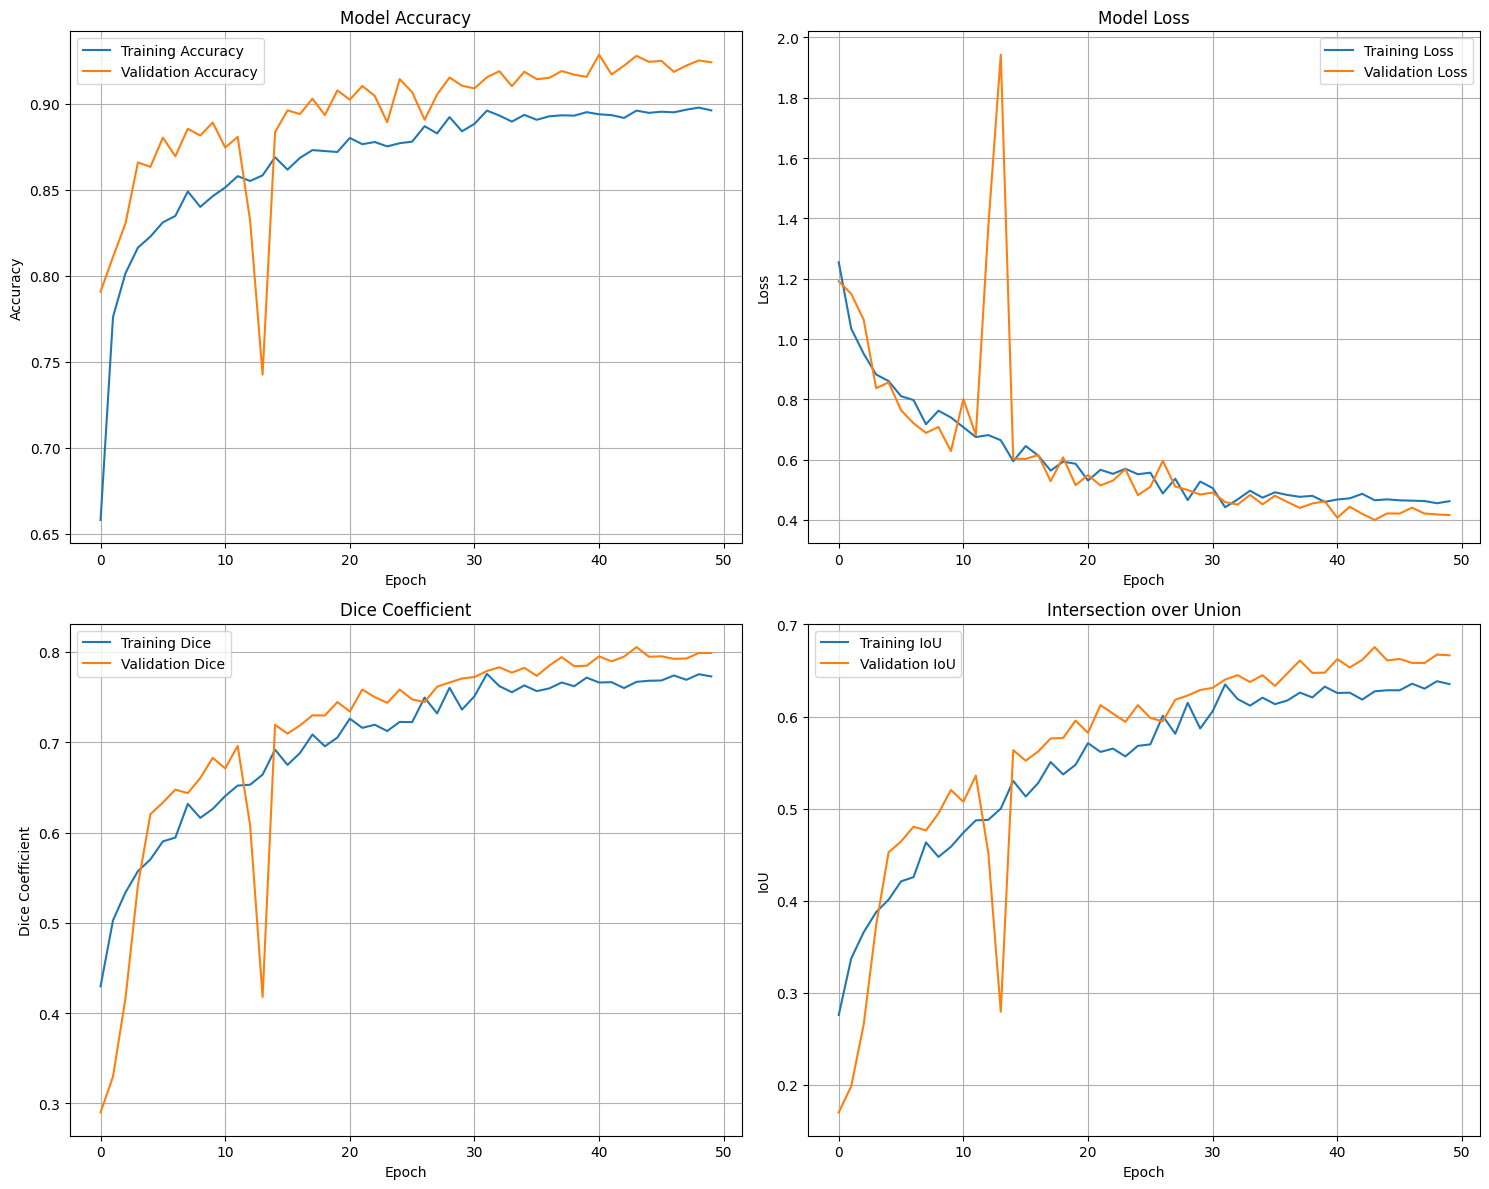


Final Training Metrics:
  Accuracy: 0.8961
  Dice Coefficient: 0.7729
  IoU: 0.6353

Final Validation Metrics:
  Accuracy: 0.9241
  Dice Coefficient: 0.7989
  IoU: 0.6665


In [ ]:


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Dice Coefficient
axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice Coefficient')
axes[1, 0].set_title('Dice Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True)

# IoU
axes[1, 1].plot(history.history['iou_metric'], label='Training IoU')
axes[1, 1].plot(history.history['val_iou_metric'], label='Validation IoU')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('IoU')
axes[1, 1].set_title('Intersection over Union')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

#  final metrics
print(f"\nFinal Training Metrics:")
print(f"  Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Dice Coefficient: {history.history['dice_coefficient'][-1]:.4f}")
print(f"  IoU: {history.history['iou_metric'][-1]:.4f}")

print(f"\nFinal Validation Metrics:")
print(f"  Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Dice Coefficient: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"  IoU: {history.history['val_iou_metric'][-1]:.4f}")

In [ ]:

# Predict on training data
preds_train = model.predict(X_train_norm, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)

# Predict on validation data
preds_val = model.predict(X_val_norm, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Predict on test data
preds_test = model.predict(X_test_norm, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

print(f"\nPrediction shapes:")
print(f"  Training predictions: {preds_train_t.shape}")
print(f"  Validation predictions: {preds_val_t.shape}")
print(f"  Test predictions: {preds_test_t.shape}")



Making predictions on all datasets...
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step

Prediction shapes:
  Training predictions: (1999, 128, 128, 1)
  Validation predictions: (500, 128, 128, 1)
  Test predictions: (441, 128, 128, 1)


## Eval Metrices

In [ ]:

from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    """Calculate segmentation metrics"""
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')
    dice = f1_score(y_true_flat, y_pred_flat, average='binary')
    precision = precision_score(y_true_flat, y_pred_flat, average='binary', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='binary', zero_division=0)

    return {
        'IoU': iou,
        'Dice': dice,
        'Precision': precision,
        'Recall': recall
    }



In [ ]:

# Training metrics
train_metrics = calculate_metrics(Y_train, preds_train_t)
print(f"\nTraining Set:")
print(f"  IoU (Jaccard):     {train_metrics['IoU']:.4f}")
print(f"  Dice Coefficient:  {train_metrics['Dice']:.4f}")
print(f"  Precision:         {train_metrics['Precision']:.4f}")
print(f"  Recall:            {train_metrics['Recall']:.4f}")

# Validation metrics
val_metrics = calculate_metrics(Y_val, preds_val_t)
print(f"\nValidation Set:")
print(f"  IoU (Jaccard):     {val_metrics['IoU']:.4f}")
print(f"  Dice Coefficient:  {val_metrics['Dice']:.4f}")
print(f"  Precision:         {val_metrics['Precision']:.4f}")
print(f"  Recall:            {val_metrics['Recall']:.4f}")

# Test metrics
test_metrics = calculate_metrics(Y_test, preds_test_t)
print(f"\nTest Set:")
print(f"  IoU (Jaccard):     {test_metrics['IoU']:.4f}")
print(f"  Dice Coefficient:  {test_metrics['Dice']:.4f}")
print(f"  Precision:         {test_metrics['Precision']:.4f}")
print(f"  Recall:            {test_metrics['Recall']:.4f}")



Training Set:
  IoU (Jaccard):     0.7280
  Dice Coefficient:  0.8426
  Precision:         0.8183
  Recall:            0.8684

Validation Set:
  IoU (Jaccard):     0.7126
  Dice Coefficient:  0.8322
  Precision:         0.8126
  Recall:            0.8527

Test Set:
  IoU (Jaccard):     0.7197
  Dice Coefficient:  0.8370
  Precision:         0.8141
  Recall:            0.8613


## Gradcam visualization in testing

In [ ]:

def make_gradcam_heatmap(img_array: np.ndarray, model: tf.keras.Model, last_conv_layer_name: str, pred_index: int | None = None) -> np.ndarray:
    """
    Generate Grad-CAM heatmap for the given image.

    Args:
        img_array: Input image array (batch_size, height, width, channels)
        model: Keras model
        last_conv_layer_name: Name of the last convolutional layer
        pred_index: Index of the class to visualize (None for regression/segmentation)

    Returns:
        heatmap: 2D array of the same size as the input image
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.reduce_mean(preds)
        else:
            pred_index = preds[:, pred_index]

    grads = tape.gradient(pred_index, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    heatmap = heatmap.numpy()

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = heatmap.astype(np.float32) / 255.0

    return heatmap

def visualize_predictions_with_gradcam(X_data: np.ndarray, Y_true: np.ndarray, Y_pred: np.ndarray, model: tf.keras.Model, last_conv_layer_name: str, num_samples: int = 3) -> None:
    """
    Visualizes random samples from the dataset with original image, ground truth, predicted mask,
    and Grad-CAM heatmap overlayed on the original image.

    Args:
        X_data: Input images
        Y_true: True Masks
        Y_pred: Predicted Masks
        model: The trained model
        last_conv_layer_name: Layer name for GradCAM
        num_samples: Number of samples to visualize
    """
    indices = np.random.choice(len(X_data), num_samples, replace=False)

    for i, idx in enumerate(indices):
        original_img = X_data[idx]
        true_mask = Y_true[idx]
        predicted_mask = Y_pred[idx]


        img_array_for_gradcam = np.expand_dims(original_img.astype('float32') / 255.0, axis=0)


        heatmap = make_gradcam_heatmap(img_array_for_gradcam, model, last_conv_layer_name)

        #  RGB image of the heatmap
        jet = cm.get_cmap("jet")
        jet_colors = jet(heatmap)[:, :, :3]
        jet_heatmap = (jet_colors * 255).astype(np.uint8)

        superimposed_img = jet_heatmap * 0.4 + original_img * 0.6
        superimposed_img = superimposed_img.astype(np.uint8)

        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(original_img)
        plt.title(f'Original Image {idx}')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(np.squeeze(true_mask), cmap='gray')
        plt.title(f'Ground Truth Mask {idx}')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(np.squeeze(predicted_mask), cmap='gray')
        plt.title(f'Predicted Mask {idx}')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(superimposed_img)
        plt.title(f'Grad-CAM Overlay {idx}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()



In [ ]:
# Find the last Conv2D layer just for chekcingg
conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
last_conv_layer_name = conv_layers[-2]
print(f"Using layer '{last_conv_layer_name}' for Grad-CAM visualization")



Using layer 'conv2d_17' for Grad-CAM visualization


/tmp/ipython-input-768172022.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


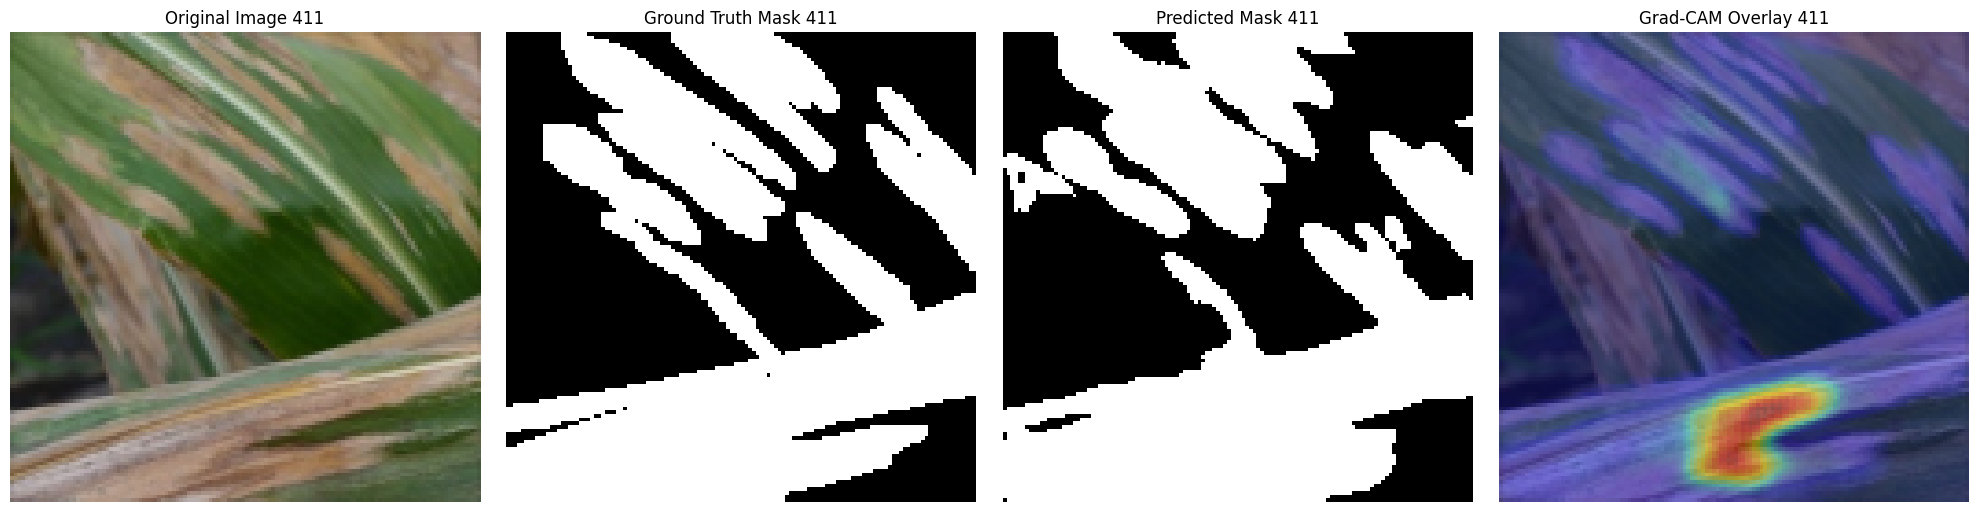

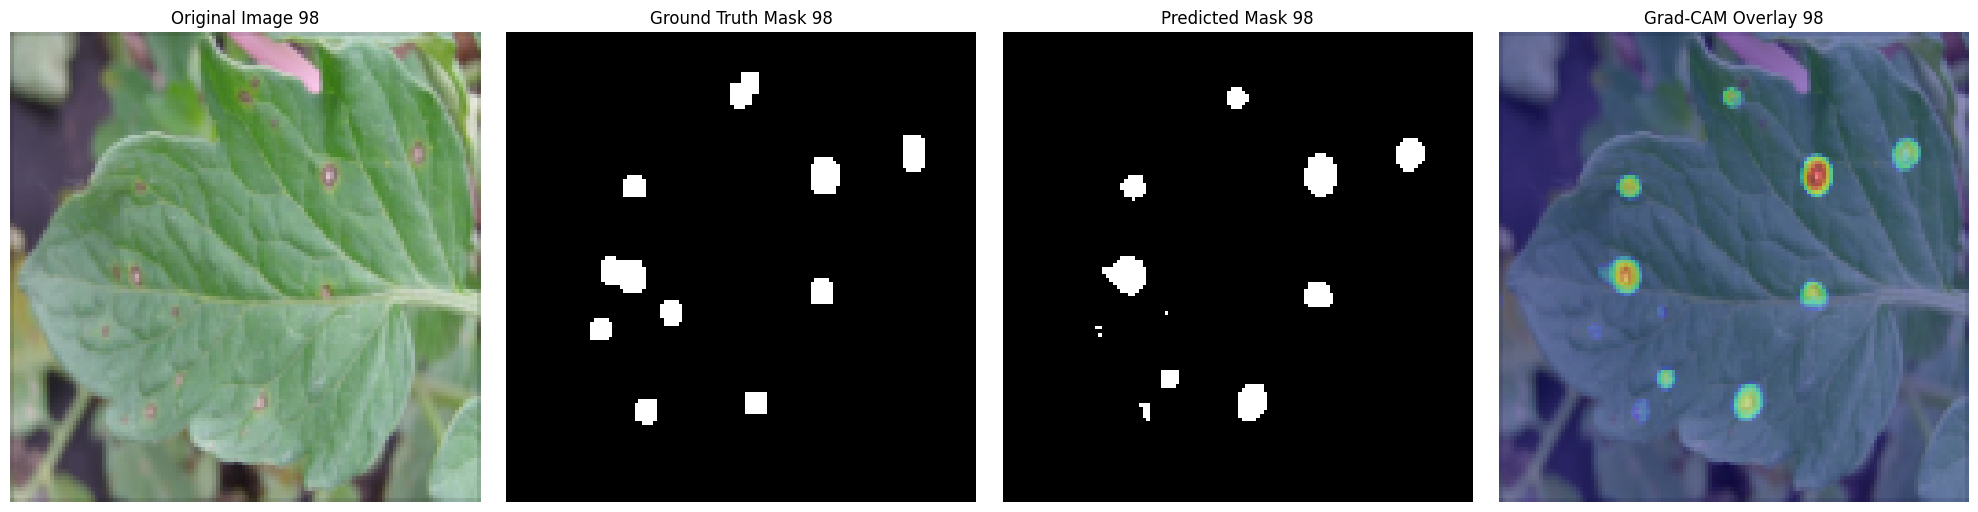

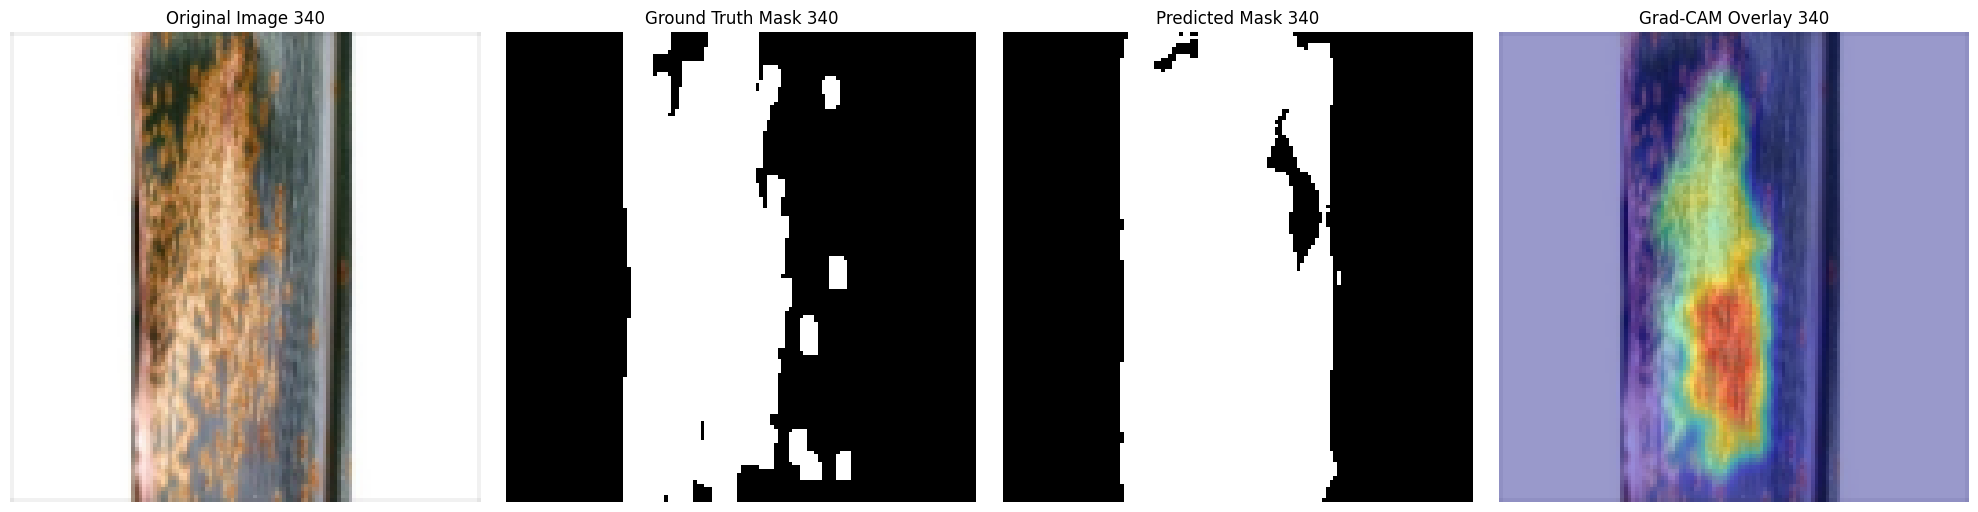

In [ ]:

visualize_predictions_with_gradcam(
    X_test,
    Y_test,
    preds_test_t,
    model,
    last_conv_layer_name,
    num_samples=3
)

## Confusion Mtrix

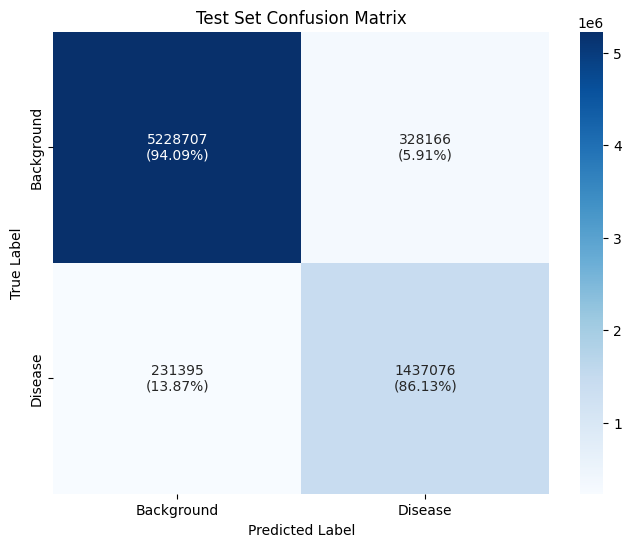

------------------------------
RAW COUNTS:
True Negatives (TN): 5228707
False Positives (FP): 328166
False Negatives (FN): 231395
True Positives (TP): 1437076
------------------------------
PERCENTAGE METRICS:
Accuracy:    92.26%
Precision:   81.41%
Recall:      86.13% (Sensitivity)
Specificity: 94.09%
F1 Score:    83.70
IoU Score:   71.97%
------------------------------


In [ ]:

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str = "Confusion Matrix") -> None:
    """
    Plots a confusion matrix for pixel-wise classification with counts and percentages.

    Args:
        y_true: Ground truth masks
        y_pred: Predicted masks
        title: Title for the plot
    """

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()


    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # This says us that "Of all pixels that were actually X, what % did we predict correctly? similar to BCE"
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


    annot_labels = [f"{count}\n({percent:.2f}%)"
                    for count, percent in zip(cm.flatten(), cm_percent.flatten())]
    annot_labels = np.asarray(annot_labels).reshape(cm.shape)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
                xticklabels=['Background', 'Disease'],
                yticklabels=['Background', 'Disease'])

    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100 if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0 # Sensitivity
    specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) / 100 if (precision + recall) > 0 else 0 #  here scaled for consistency from 0 to 1
    iou = tp / (tp + fp + fn) * 100 if (tp + fp + fn) > 0 else 0

    print("-" * 30)
    print("RAW COUNTS:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    print("-" * 30)
    print("PERCENTAGE METRICS:")
    print(f"Accuracy:    {accuracy:.2f}%")
    print(f"Precision:   {precision:.2f}%")
    print(f"Recall:      {recall:.2f}% (Sensitivity)")
    print(f"Specificity: {specificity:.2f}%")
    print(f"F1 Score:    {f1_score * 100:.2f}") # F1 is usually 0-1 but we will be  multiplying for display
    print(f"IoU Score:   {iou:.2f}%")
    print("-" * 30)



plot_confusion_matrix(Y_test, preds_test_t, title="Test Set Confusion Matrix")

## Conclusion

This project successfully developed and evaluated a U-Net model for leaf disease segmentation. The workflow encompassed several critical steps:

1.  **Dataset Preparation**: The dataset was downloaded from Kaggle, organized, and split into training, validation, and holdout test sets using a 5-fold cross-validation strategy. Data augmentation was applied during training to improve model robustness.

2.  **Data Preprocessing**: Images and masks were loaded and resized to a consistent `128x128` resolution. Images were normalized to a `[0, 1]` range, and masks were converted to float format.

3.  **U-Net Model Development**: A U-Net architecture was built with an encoder-decoder structure, incorporating Batch Normalization and Dropout layers to enhance training stability and prevent overfitting. The model was compiled using a combined Binary Cross-Entropy and Dice Loss function, optimized with Adam, and monitored for accuracy, Dice Coefficient, and IoU.

4.  **Model Training**: The U-Net model was trained for 50 epochs with callbacks for model checkpointing, early stopping, and learning rate reduction. The model demonstrated good learning progress, as indicated by the training history plots.

5.  **Performance Evaluation**: The trained model achieved the following performance metrics on the holdout test set:
    *   **IoU (Jaccard Index)**: 0.7197
    *   **Dice Coefficient (F1-Score)**: 0.8370
    *   **Precision**: 0.8141
    *   **Recall**: 0.8613

    The pixel-wise confusion matrix further detailed the model's classification capabilities:
    *   **Accuracy**: 92.26%
    *   **Precision**: 81.41%
    *   **Recall (Sensitivity)**: 86.13%
    *   **Specificity**: 94.09%

    These metrics indicate that the model effectively identifies diseased areas, with a good balance between precision and recall.

6.  **Interpretability with Grad-CAM**: Grad-CAM visualizations provided insight into which regions of the input images the model focused on when making predictions. This helps in understanding the model's decision-making process and confirming its attention to relevant disease features.

In summary, this project successfully developed a U-Net based semantic segmentation model capable of accurately identifying leaf disease areas. The robust data preparation and training methodology, coupled with a well-designed U-Net architecture, contributed to strong performance metrics and interpretability, making it a promising solution for automated plant disease detection.